# 02 — Observable Modeling with Tudat

This notebook defines and simulates radio science observables (one-way and two-way range) for a spacecraft orbiting Jupiter, observed from Earth-based ground stations.

Focus in environment and ground station setup; definition of observable types; computation of simulated observables (no estimation yet)


#### - Imports

In [1]:
import numpy as np
from matplotlib import pyplot as plt

from tudatpy.interface import spice
from tudatpy import dynamics
from tudatpy.dynamics import environment_setup, propagation_setup
from tudatpy.estimation import observable_models_setup, observations_setup, estimation_analysis
from tudatpy.estimation.observable_models_setup import links, model_settings
from tudatpy.estimation.observable_models_setup.links import LinkEndType
from tudatpy.estimation.observable_models_setup.model_settings import one_way_range, ObservableType
from tudatpy.astro import element_conversion
from tudatpy import constants
from tudatpy.astro.time_representation import DateTime

#### - Definition of celestial bodies, simulation epoch and spacecraft

In [41]:
# Load SPICE kernels
spice.load_standard_kernels()

# Reference epoch
simulation_start_epoch = DateTime(2016, 10, 5).to_epoch()
simulation_end_epoch   = simulation_start_epoch + 2.0 * 24.0 * 3600.0

# Bodies to include
bodies_to_create = ["Sun", "Jupiter", "Earth"]

# Global frame
global_frame_origin = "Jupiter"
global_frame_orientation = "ECLIPJ2000"

# Create body settings
body_settings = environment_setup.get_default_body_settings(
    bodies_to_create,
    global_frame_origin,
    global_frame_orientation
)



In [59]:
body_settings.add_empty_settings("Juno")

body_settings.get("Juno").constant_mass = 2e3  #2000 kg

jupiter_gravitational_parameter = constants.GRAVITATIONAL_CONSTANT * 1.898e27  

semi_major_axis = 1.07e9
eccentricity = 0.95
inclination = np.deg2rad(90.0)
argument_of_periapsis = np.deg2rad(0.0)
longitude_of_ascending_node = np.deg2rad(0.0)
true_anomaly = np.deg2rad(0.0)

keplerian_elements = [
    semi_major_axis,
    eccentricity,
    inclination,
    argument_of_periapsis,
    longitude_of_ascending_node,
    true_anomaly
]

juno_ephemeris_settings = environment_setup.ephemeris.keplerian(
    keplerian_elements,
    simulation_start_epoch,
    jupiter_gravitational_parameter,
    global_frame_origin,
    global_frame_orientation
)

body_settings.get("Juno").ephemeris_settings = juno_ephemeris_settings

reference_area_radiation = 50.0  # m²
radiation_pressure_coefficient = 1.2
occulting_bodies_dict = {"Sun": ["Jupiter", "Earth"]}

body_settings.get("Juno").radiation_pressure_target_settings = (
    environment_setup.radiation_pressure.cannonball_radiation_target(
        reference_area_radiation,
        radiation_pressure_coefficient,
        occulting_bodies_dict
    )
)

bodies = environment_setup.create_system_of_bodies(body_settings)

#### - Criating a ground station

In [61]:
environment_setup.add_ground_station(
    bodies.get_body("Earth"),
    "DSS-14",
    np.array([0.0, 0.0, 0.0]),
    element_conversion.PositionElementTypes.cartesian_position_type
)

#### - Define observable types and observation times

In [62]:
link_ends = dict()

link_ends[LinkEndType.transmitter] = (
    links.body_origin_link_end_id("Juno")
)

link_ends[LinkEndType.receiver] = (
    links.body_reference_point_link_end_id("Earth", "DSS-14")
)

link_definition = links.LinkDefinition(link_ends)

observable_settings = [
    one_way_range(link_definition)
]

In [63]:
observation_times = np.linspace(
    simulation_start_epoch,
    simulation_end_epoch,
    50
)

#### - Observation Simulation

In [64]:
observation_simulators = observations_setup.observations_simulation_settings.create_observation_simulators(
    observable_settings,
    bodies
)

simulation_settings = observations_setup.observations_simulation_settings.tabulated_simulation_settings(
    observable_models_setup.model_settings.ObservableType.one_way_range_type,
    link_definition,
    observation_times
)

observations = observations_setup.observations_wrapper.simulate_observations(
    [simulation_settings],
    observation_simulators,
    bodies
)

#### - Visualization

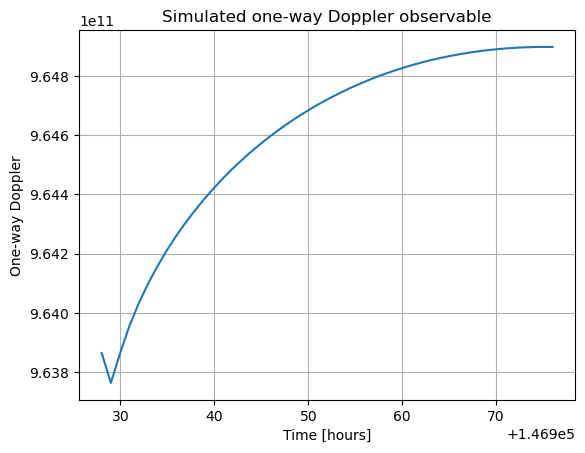

In [65]:
doppler_values = observations.concatenated_observations

plt.figure()
plt.plot(observation_times / 3600, doppler_values)
plt.xlabel("Time [hours]")
plt.ylabel("One-way Doppler")
plt.title("Simulated one-way Doppler observable")
plt.grid()
plt.show()
